In [1]:
#!pip install qulacs
#!pip install matplotlib
#!pip install numpy
#!pip install scipy
#!pip install tqdm

from utility import *

In [15]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import random
from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix,RandomUnitary,DepolarizingNoise
from qulacs.circuit import QuantumCircuitOptimizer

# ランダム量子回路と量子ボリューム


ランダムな量子状態の確立分布はどのようになるかをまず確認しよう。

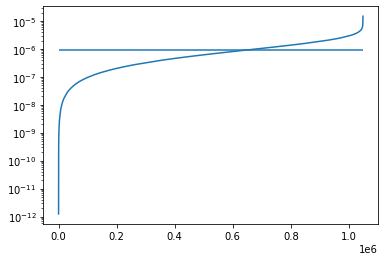

In [3]:
nqubits = 20
state = QuantumState(nqubits)
state.set_Haar_random_state()

#確率分布を取得
prob_dist = [abs(x)**2 for x in state.get_vector()]

#小さい順に並べてプロット
plt.plot(np.sort(prob_dist))
plt.hlines(1/2**nqubits, 0, 2**nqubits)
plt.yscale("log")
plt.show()

一様分布 $p(x) = \cfrac{1}{2^{nqubits}}$ よりも高い確率で出現するビット列が存在。

## ランダム量子回路
$n$（偶数）量子ビットをランダムにペアに分けて、ランダムな2量子ビット演算を実行するような量子回路を構成しよう。

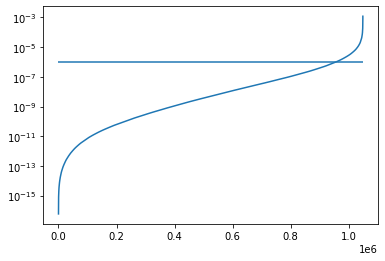

In [4]:
nqubits = 20
depth = 1
state = QuantumState(nqubits)
random_circuit = QuantumCircuit(nqubits)

qubit_index = [i for i in range(nqubits)]

random_circuit_instance =[]

for _ in range(depth):
    #qubitのindexをランダムに置換する
    random.shuffle(qubit_index)
    for k in range(int(nqubits/2)):
        #ランダムに選んだペアにランダム量子演算を作用
        random_circuit_instance.append(RandomUnitary([qubit_index[2*k],qubit_index[2*k+1]]))

#ゲートの総数
gate_counts = len(random_circuit_instance)        

#ゲートを追加
for i in range(gate_counts):
    random_circuit.add_gate(random_circuit_instance[i])

#状態を更新
random_circuit.update_quantum_state(state)

#確率分布を取得
prob_dist = [abs(x)**2 for x in state.get_vector()]

#小さい順に並べてプロット
plt.plot(np.sort(prob_dist))
plt.hlines(1/2**nqubits, 0, 2**nqubits)
plt.yscale("log")
plt.show()

depthが浅いと少し偏った分布になる。

In [5]:
def random_unitary_gate_set(nqubits,depth):
    random_circuit_instance =[]
    qubit_index = [i for i in range(nqubits)]

    for _ in range(depth):
        #qubitのindexをランダムに置換する
        random.shuffle(qubit_index)
        for k in range(int(nqubits/2)):
            #ランダムに選んだペアにランダム量子演算を作用
            random_circuit_instance.append(RandomUnitary([qubit_index[2*k],qubit_index[2*k+1]]))

    return random_circuit_instance

def random_circuit_sampling(nqubits,random_circuit_instance):
    state = QuantumState(nqubits)
    random_circuit = QuantumCircuit(nqubits)

    #ゲートの総数
    gate_counts = len(random_circuit_instance)        

    #ゲートを追加
    for i in range(gate_counts):
        random_circuit.add_gate(random_circuit_instance[i])

    #状態を更新
    random_circuit.update_quantum_state(state)


    #確率分布を取得
    prob_dist = [abs(x)**2 for x in state.get_vector()]

    #小さい順に並べてプロット
    plt.plot(np.sort(prob_dist))
    plt.hlines(1/2**nqubits, 0, 2**nqubits)
    plt.yscale("log")
    plt.show()

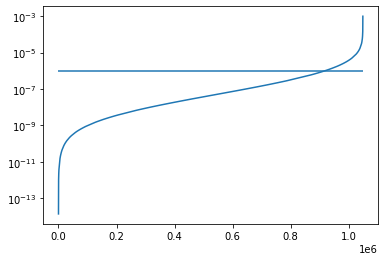

In [6]:
nqubits=20
depth = 2
random_circuit_sampling(nqubits,random_unitary_gate_set(nqubits,depth))

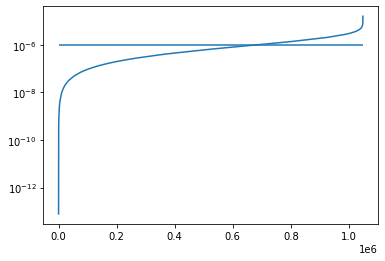

In [7]:
nqubits=20
depth = 10
random_circuit_sampling(nqubits,random_unitary_gate_set(nqubits,depth))

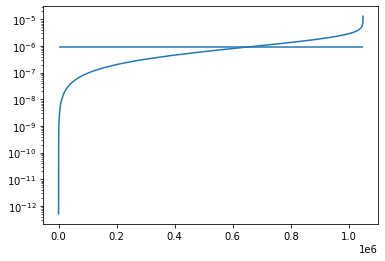

In [8]:
nqubits=20
depth=20
random_circuit_sampling(nqubits,random_unitary_gate_set(nqubits,depth))

## Heavy Output を生成する

In [3]:
def HeavyOutput(nqubits,random_circuit_instance):
    state = QuantumState(nqubits)
    random_circuit = QuantumCircuit(nqubits)

    #ゲートの総数
    gate_counts = len(random_circuit_instance)

    #ゲートを追加
    for i in range(gate_counts):
        random_circuit.add_gate(random_circuit_instance[i])
        

    #状態を更新
    random_circuit.update_quantum_state(state)


    #確率分布を取得
    prob_dist = [abs(x)**2 for x in state.get_vector()]
    
    #小さい順に並べて中央値を取り出す
    p_median = np.sort(prob_dist)[2**(nqubits-1)-1]
    
    heavy_output = []
    for i in range(2**nqubits):
        #中央値よりも確率が高くなる側て結果を集める
        if prob_dist[i] > p_median:
            heavy_output.append(i)
    return heavy_output

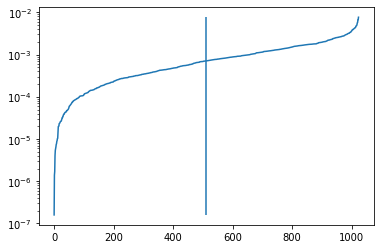

0.8413633846218864


In [13]:
nqubits = 10
depth = 10
random_circuit_instance = random_unitary_gate_set(nqubits,depth)

state = QuantumState(nqubits)
random_circuit = QuantumCircuit(nqubits)

#ゲートの総数
gate_counts = len(random_circuit_instance)

#ゲートを追加
for i in range(gate_counts):
    random_circuit.add_gate(random_circuit_instance[i])

#状態を更新
random_circuit.update_quantum_state(state)


#確率分布を取得
prob_dist = [abs(x)**2 for x in state.get_vector()]

heavy_output = HeavyOutput(nqubits,random_circuit_instance)

#確率分布をプロット
plt.plot(np.sort(prob_dist))
plt.vlines(2**(nqubits-1)-1, min(prob_dist), max(prob_dist)) # 中央値
plt.yscale("log")
plt.show()

heavy_prob = 0
for i in heavy_output:
    heavy_prob += prob_dist[i]

print(heavy_prob)

さて、$n$量子ビット、深さ$d$のランダム量子回路で、heavy outputを得る確率が$\cfrac{2}{3}$以上だった場合にタスクが成功するとする。このとき、量子ボリューム（量子コンピューターの性能を図る指標で、どのくらい大きい回路までならノイズが許容範囲で計算ができるかを定めたもの）は、$QV= max( 2^{min(n,d)})$ で定義される。

## 実際にサンプリングをして、heavy outputを得る確率を推定してみよう

In [29]:
# heavy outputを得る確率
def heavy_output_probability(circuit, nqubits, shots, heavy_output):
    state = QuantumState(nqubits)
    
    # 状態を更新
    circuit.update_quantum_state(state)
    
    # サンプリングを実行
    outcome = state.sampling(shots)
    
    # 確率分布を計算してプロット
    counter = Counter(outcome)
    prob_dist = [counter[i] / shots for i in range(2**nqubits)]
    plt.plot(np.sort(prob_dist))
    plt.yscale("log")
    plt.show()
    
    # heavy output の確率を計算
    estimated_heavy_prob = 0
    for i in heavy_output:
        estimated_heavy_prob += counter[i] / shots
    return estimated_heavy_prob

理想的な量子回路の場合：

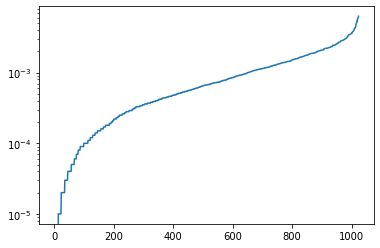

0.8466499999999996


In [42]:
nqubits = 10
depth = nqubits
shots =100000

# random circuitのインスタンスを生成
random_circuit = QuantumCircuit(nqubits)
random_circuit_instance = random_unitary_gate_set(nqubits,depth)

# heavy outputの計算
heavy_output = HeavyOutput(nqubits,random_circuit_instance)

#ゲートの総数
gate_counts = len(random_circuit_instance)

#ゲートを追加
for i in range(gate_counts):
    random_circuit.add_gate(random_circuit_instance[i])

# heavy outputの観測率を計算
estimated_heavy_prob = heavy_output_probability(random_circuit, nqubits, shots, heavy_output)
print(estimated_heavy_prob)


ノイズのある回路の場合：

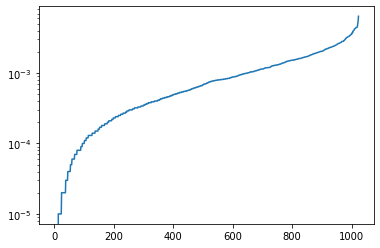

0.8418799999999999


In [43]:
nqubits = 10
depth = nqubits
shots =100000
error_prob = 0.001

# random circuitのインスタンスを生成
random_circuit_instance = random_unitary_gate_set(nqubits,depth)

# heavy outputの計算
heavy_output = HeavyOutput(nqubits,random_circuit_instance)

#ゲートの総数
gate_counts = len(random_circuit_instance)

#ゲートを追加
random_circuit = QuantumCircuit(nqubits)
for i in range(gate_counts):
    random_circuit.add_gate(random_circuit_instance[i])
    for k in range(nqubits):
        #１量子ビットのdepolarzingNoiseを作用させる
        random_circuit.add_gate(DepolarizingNoise(k,error_prob))
        
# heavy outputの観測率を計算
estimated_heavy_prob = heavy_output_probability(random_circuit, nqubits, shots, heavy_output)
print(estimated_heavy_prob)


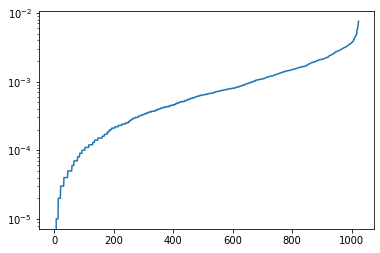

0.5117299999999996


In [44]:
nqubits = 10
depth = nqubits
shots =100000
error_prob = 0.01

# random circuitのインスタンスを生成
random_circuit_instance = random_unitary_gate_set(nqubits,depth)

# heavy outputの計算
heavy_output = HeavyOutput(nqubits,random_circuit_instance)

#ゲートの総数
gate_counts = len(random_circuit_instance)

#ゲートを追加
random_circuit = QuantumCircuit(nqubits)
for i in range(gate_counts):
    random_circuit.add_gate(random_circuit_instance[i])
    for k in range(nqubits):
        #１量子ビットのdepolarzingNoiseを作用させる
        random_circuit.add_gate(DepolarizingNoise(k,error_prob))
        
# heavy outputの観測率を計算
estimated_heavy_prob = heavy_output_probability(random_circuit, nqubits, shots, heavy_output)
print(estimated_heavy_prob)
